In [390]:
import torch
from utils import models, nethook, activ, matching, helpers, dictionary, neuron_finding,cam
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import pandas as pd
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm
import torch.nn as nn
from torchvision.transforms import ToPILImage
import pandas as pd

In [391]:
def reshape_transform(tensor, height=14, width=14):
    # 去掉类别标记
    result = tensor[:, 1:, :].reshape(tensor.size(0),
    height, width, tensor.size(2))

    # 将通道维度放到第一个位置
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def draw_bar_chart(label_number,pkl_file,save_path,methods="abs"):
    print(f"Draw bar chart for label {label_number}...")
    f = open(pkl_file,"rb")
    data = pickle.load(f) #[weights, max_activations, mean_activations]
    f.close()

    weights = data[:, :, 0]
    activation =data[:,:,2]

    plt.clf()
    sample_number = weights.shape[0]
    if methods=="abs":
        weights = np.abs(weights)
    weight_accumulator = np.sum(weights, axis=0)
    average_gradients = weight_accumulator / sample_number

    # 估计每个卷积核的Shapley值
    importance = average_gradients.flatten()
    categories = list(range(importance.shape[0]))
    dot_size = 4
    plt.figure(figsize=(20, 10))
    plt.scatter(categories, importance, s=dot_size)  # 绘制散点图，每个点的大小为1

    directory_path = os.path.dirname(save_path)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # 添加标题和标签
    plt.title(f'Neuron Weight for identifying class {label_number}')
    plt.xlabel('Neuron')
    plt.ylabel('Values')
    plt.savefig(os.path.join(save_path,"weight_plot.png"), format='png')

    print(f"Draw Finish! in {save_path}/weight_plot.png")

    plt.clf()
    sample_number = weights.shape[0]
    if methods=="abs":
        activation = np.abs(activation)
    activation_accumulator = np.sum(activation, axis=0)
    average_activation = activation_accumulator / sample_number

    # 估计每个卷积核的Shapley值
    importance = average_activation.flatten()
    categories = list(range(importance.shape[0]))
    dot_size = 4
    plt.figure(figsize=(20, 10))
    plt.scatter(categories, importance, s=dot_size)  # 绘制散点图，每个点的大小为1

    directory_path = os.path.dirname(save_path)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # 添加标题和标签
    plt.title(f'Neuron Activation for identifying class {label_number}')
    plt.xlabel('Neuron')
    plt.ylabel('Values')
    plt.savefig(os.path.join(save_path,"activation_plot.png"), format='png')

    print(f"Draw Finish! in {save_path}/activation_plot.png")

In [392]:
label = "all"
folder_path = "/export/home/wuyueting/Chest_data/chexpert/"
test_csv =  "/export/home/wuyueting/Chest_data/chexpert/test_labels.csv"

# folder_path = "/export/home/wuyueting/Classification/Singlelabel/Densenet-case/chexpert/"
# test_csv = "/export/home/wuyueting/Classification/Singlelabel/Densenet-case/chexpert/CheXpert-v1.0-small/valid.csv"
model_name = "chest_resnet152"
target_layer="model.layer4[-1]"
target_save_name = model_name+target_layer
attr_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

preprocess = transforms.Compose([
    transforms.Resize(320),
    transforms.CenterCrop(320),
    lambda x: torch.from_numpy(np.array(x, copy=True)).float().div(255).unsqueeze(0),   # tensor in [0,1]
    transforms.Normalize(mean=[0.5330], std=[0.0349]),                                           # whiten with dataset mean and std
    lambda x: x.expand(3,-1,-1)]) 


In [393]:

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
def chest_main():
    df = pd.read_csv(test_csv)
    image_files  = df.iloc[:, 0].tolist()
    image_files = [os.path.join(folder_path, x) for x in image_files]
    # df_selected = df[attr_names]
    activ.get_same_class_stats(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{label}.pkl", label_csv =df, attr_names = attr_names,folder_path=folder_path)
    
    # activ.get_same_class_similarity_matrix(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{label}_similarity.pkl")
    # print(f"activs_stats/{target_save_name}/{label}.pkl")
    

    neuron_finding.visualize_all_neuron(model_name,target_layer,image_files,label,\
                                                                                        6,\
                                                                                        f"activs_stats/{target_save_name}",\
                                                                                        f"matching_result/{target_save_name}/{label}/",visualize=True)
    
    fc_file = "activs_stats/chest_resnet152model.fc/all.pkl"
    f = open(fc_file, 'rb')
    fc_data = pickle.load(f)
    f.close()
    print(fc_data.shape)
    activation = fc_data[:,:,1]
    print(activation.shape)
    for i,attr in enumerate(attr_names):
        print(attr)
        label_activation = activation[:,i]
        #找出最大的10个激活
        max_idxs = np.argsort(label_activation)[::-1][:10]
        print(df.loc[max_idxs,"Path"])
        print(df.loc[max_idxs,attr])
        

    # os.makedirs(f"matching_result/{target_save_name}/{label}", exist_ok=True)
    # draw_bar_chart(label,f"activs_stats/{target_save_name}/{label}.pkl",save_path=f"matching_result/{target_save_name}/{label}",methods=None)

    return

# chest_main()

In [394]:
abbreviation_dict = {
    "volume loss": "VL",
    "displacement of fissures": "DF",
    "air bronchograms": "AB",
    "silhouette sign": "SS",
    "increased opacity": "IO",
    "enlarged heart silhouette": "EHS",
    "increased cardiothoracic ratio": "ICTR",
    "prominent vascular markings": "PVM",
    "pulmonary congestion": "PC",
    "effacement of pleural margins": "EPM",
    "homogeneous opacity": "HO",
    "loss of air bronchograms": "LAB",
    "silhouette sign with adjacent structures": "SSAS",
    "ground-glass appearance": "GGA",
    "airspace opacification": "AO",
    "bilateral pleural effusions": "BPE",
    "kerley b lines": "KBL",
    "peribronchial cuffing": "PBC",
    "ground-glass opacities": "GGO",
    "interstitial thickening": "IT",
    "blunting of costophrenic angles": "BCA",
    "meniscus sign": "MS",
    "fluid layering on decubitus views": "FLDV",
    "mediastinal shift": "MDS",
    "increased density on ultrasound": "IDU",
    "atelectasis in CT": "ATCT",
    "cardiomegaly in CT": "CMCT",
    "consolidation in CT": "CCT",
    "edema in CT": "ECT",
    "pleural Effusion in CT": "PECT"
}

In [395]:
def get_categories_and_colormap():
    categories = {
"Atelectasis" : [
    "atelectasis in CT",
    "volume loss",
    "displacement of fissures",
    "air bronchograms",
    "silhouette sign",
    "increased opacity",
    "enlarged heart silhouette"
],

"Cardiomegaly" : [
    "cardiomegaly in CT",
    "enlarged heart silhouette",
    "increased cardiothoracic ratio",
    "prominent vascular markings",
    "pulmonary congestion",
    "effacement of pleural margins",
],

"Consolidation" : [
    "consolidation in CT",
    "homogeneous opacity",
    "loss of air bronchograms",
    "silhouette sign with adjacent structures",
    "ground-glass appearance",
    "airspace opacification",
],

"Edema" : [
    "edema in CT",
    "bilateral pleural effusions",
    "kerley b lines",
    "peribronchial cuffing",
    "ground-glass opacities",
    "interstitial thickening",
],

# Echo-related lesions
"Pleural effusion" : [
    "pleural Effusion in CT",
    "blunting of costophrenic angles",
    "meniscus sign",
    "fluid layering on decubitus views",
    "mediastinal shift",
    "increased density on ultrasound",
],


}
    color_map = {
        'Atelectasis': '#605678',
        'Cardiomegaly': '#7AB2D3',
        'Consolidation': '#8ABFA3',
        'Edema': '#FFBF61',
        'Pleural effusion':'#FFE6A5',}
    return categories, color_map

In [396]:
def get_filename(model_name,clipmodel_name):
    if clipmodel_name == "biomedclip":
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/chest_resnet152_24_10_21_16_16/descriptions.csv" ##CHEST
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/chest_resnet152_24_10_22_13_58/descriptions.csv" ##CHEST2
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/chest_resnet152_24_10_22_14_04/descriptions.csv" ##CHEST3
    return filename

In [397]:
def apply_importance_matric(ori_gradients,ori_activations,importance_matric):
    
    gradient_type = importance_matric.split("_")[0]
    activation_type = importance_matric.split("_")[1]
    
    stn_gradients = ori_gradients/np.max(np.abs(ori_gradients))
    stn_activations = (ori_activations - np.min(ori_activations)) / (np.max(ori_activations) - np.min(ori_activations))
    abs_gradients = np.abs(ori_gradients)
    
    if gradient_type == "abs":
        gradients = abs_gradients
    elif gradient_type == "stn":
        gradients = stn_gradients
    elif gradient_type == "ori":
        gradients = ori_gradients
    elif gradient_type == "stnabs":
        gradients = np.abs(stn_gradients)
    elif gradient_type =="sq":
        gradients = ori_gradients**2
        
    if activation_type == "stn":
        activations = stn_activations
    elif activation_type == "ori":
        activations = ori_activations
    elif activation_type == "abs":
        activations = np.abs(ori_activations)
    elif activation_type == "pos":
        min_act = np.min(ori_activations)
        if min_act < 0 :
            activations = ori_activations + np.abs(min_act)
        else:
            activations =  ori_activations
    elif activation_type == "sq":
        activations = ori_activations **2
        
    return gradients,activations

In [398]:
def get_chest_sample_dict(clipmodel_name, ori_gradients, ori_activations,top_number:int=25,importance_matric = "abs_ori", only_pos=False):
    
    gradients,activations = apply_importance_matric(ori_gradients,ori_activations,importance_matric)
    
    
    top_important_idxs, top_k_values = neuron_finding.get_max_weighted_activate_neuron(gradients, activations, k=top_number,only_pos=only_pos)
    positive_mask = top_k_values >= 0
    # 使用 np.argmax 找到第一个 False 的位置
    first_non_positive_index = np.argmax(~positive_mask)
    # 如果所有元素都是正数，则 np.argmax(~positive_mask) 将返回0（如果第一个元素为正数）
    # 需要检查是否所有元素都是正数
    if positive_mask.all():
        first_non_positive_index = len(top_k_values)
    
    
    filename = get_filename(model_name,clipmodel_name)
    df = pd.read_csv(filename)

    # print(filename)
    # unique_descriptions = set()
    sentence_parts = {}
    
    categories, _ = get_categories_and_colormap()
    for category, tags in categories.items():
        for tag in tags:
            sentence_parts[tag]=0
    total_value = 0
    for i in range(first_non_positive_index):
        id = top_important_idxs[i]
        value = top_k_values[i]
        target_row = df.iloc[id]
        description = target_row["description"] if target_row['similarity'] > 1 else "Undefined"
        if description not in sentence_parts:
            sentence_parts[description]=value
        else:
            sentence_parts[description]=sentence_parts[description]+value
        
        total_value = total_value + value
    
    result_dict = {key: value / total_value for key, value in sentence_parts.items()}
    del sentence_parts
    
    return result_dict

In [399]:
import matplotlib.patches as patches
def draw_new(label_dict,GT):
    
    categories, color_map = get_categories_and_colormap()
    # Assign colors to each row based on its category
    description_to_color = {}  # 描述到颜色的映射
    for category, items in categories.items():
        for item in items:
            description_to_color[item] = color_map[category]
    # print(color_map)
    df_filtered = pd.DataFrame(list(label_dict.items()), columns=['description', 'values'])
    
    df_filtered['category_color'] = df_filtered['description'].apply(lambda x: description_to_color.get(x, 'grey'))
    
    assert not df_filtered['category_color'].isna().any(), "在'category_color'列中存在NaN值"
    df_filtered = df_filtered[df_filtered['values']>0]
    df_filtered = df_filtered.sort_values(by=['category_color', 'values'], ascending=[True, False])
    bar_width=1
    positions = range(len(df_filtered['values']))
    # df_filtered['abbreviation'] = df_filtered['description'].map(abbreviation_dict)
    # print(df_filtered)
    unique_colors = df_filtered['category_color'].unique()
    color_blocks = {color: [] for color in unique_colors}
    last_color = None
    for i, (color, count) in enumerate(zip(df_filtered['category_color'], df_filtered['values'])):
        if color != last_color:
            if last_color is not None:
                color_blocks[last_color][-1].append(i)  # End position of the last block
            color_blocks[color].append([i])  # Start position of the new block
            last_color = color
    color_blocks[last_color][-1].append(i + 1)  # End position of the last block

    
    df_filtered['abbreviation'] = df_filtered['description'].map(abbreviation_dict)
    
    df_filtered = df_filtered[df_filtered['description']!="Undefined"]
    
    top_rows = df_filtered.nlargest(10, 'values')

    # 格式化输出
    formatted_output = [f"{row['description']}({row['values']:.2%})" for _, row in top_rows.iterrows()]

    # 打印结果
    for item in formatted_output:
        print(item)
        
    # print(df_filtered)
    plt.figure(figsize=(len(df_filtered['values'])//2, 2.5))
    plt.bar(df_filtered['abbreviation'], df_filtered['values'], color=df_filtered['category_color'],width=0.9, align='center')
    
    # plt.bar(df_filtered['description'], df_filtered['values'], color=df_filtered['category_color'],align='edge')

    # Add shaded regions for each color block
    for color, blocks in color_blocks.items():
        # print(color)
        for start, end in blocks:
            plt.axvspan(start-0.45, end-0.55 , color=color, alpha=0.4,linewidth=0)
            # rect = patches.Rectangle((start - 0.45, 0), end - start,  # 1 表示高度，适合你的数据
            #                  fill=False, edgecolor='black', linewidth=2)
            # plt.gca().add_patch(rect)
            
    # # 添加图例到图表
    # plt.legend(handles=legend_handles, title="Categories",framealpha=1.0, facecolor='white', loc='right')

    # plt.title('Number of Neuron per Description')
    plt.xticks(rotation=60, ha='right')
    # plt.subplots_adjust(left=-0.05)
    plt.tick_params(axis='y', which='both', pad=2)
    plt.tick_params(axis='x', which='both', length=0)  # 隐藏x轴的刻度线但保留标签
    plt.tick_params(axis='y', which='both', length=0)  # 隐藏y轴的刻度线    
    plt.xlim(-0.5, len(df_filtered['abbreviation']) - 0.5)
    plt.ylabel('Importance')
    # 去掉边框
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    # 显示图表
    # plt.savefig(f'layer{number}.pdf', format='pdf', transparent=True)
    plt.savefig('chest_sample.png', dpi=330,transparent=True,bbox_inches='tight')
    plt.show()
    
    
    legend_handles = []

    # 对于我们的颜色映射字典，为每个颜色创建一个图例项
    # 假设我们已经有了color_map变量
    for category, color in color_map.items():
        # 使用matplotlib.patches中的Patch对象创建图例项
        handle = mpatches.Patch(color=color, label=category)
        legend_handles.append(handle)

    # 创建一个空的图形
    fig, ax = plt.subplots()

    # 添加图例
    legend = ax.legend(handles=legend_handles, title="Category", loc='center')

    # 删除所有轴，但保留图例
    ax.axis('off')

    # 设置图形大小适合图例
    fig.canvas.draw()
    bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.set_size_inches(bbox.width, bbox.height)

    # 保存图例为图片
    plt.savefig('legend.png', dpi=330,transparent=True,bbox_inches='tight')
    # 显示图例
    plt.show()
    
    return

In [400]:
model,_ = models.load(model_name,"cuda")
weights = model.fc.weight.data



In [401]:
import matplotlib.patches as mpatches

def chest_sample_explain(i,label,top_number:int=20,importance_matric = "abs_stn"):

    df = pd.read_csv(test_csv)
    image_files  = df.iloc[:, 0].tolist()
    # image_files = [os.path.join(folder_path, x) for x in image_files]
    

    if isinstance(i,str):
        index = image_files.index(i)
        image_file = i
        i = index
        del index
    else:
        image_file = image_files[i]
        
    image_path = os.path.join(folder_path, image_file)
    
    print(image_path)
    # print(df.loc[i,attr_names])
    GT = df.loc[i, attr_names][df.loc[i, attr_names] == 1].index.tolist()
    print(GT)
    ### overall explain
    f = open(f"activs_stats/{target_save_name}/{label}.pkl","rb")
    data = pickle.load(f) #[weights, max_activations, mean_activations]
    f.close()
    
    ori_gradients = data[i, :, 0]
    ori_activations = data[i, :, 2]
    #class_weight.cpu().detach().numpy()
    label_dict = get_chest_sample_dict("biomedclip",ori_gradients,ori_activations,top_number=top_number,importance_matric = importance_matric,only_pos=False)
    draw_new(label_dict,GT)
    
    
    # for attr in attr_names:
    #     print("LABEL:",attr,df.loc[i,attr])
    #     if df.loc[i,attr] == 1:
    #         attr_index = attr_names.index(attr)
    #         f = open(f"activs_stats/{target_save_name}/{attr}.pkl","rb")
    #         data = pickle.load(f) #[weights, max_activations, mean_activations]
    #         f.close()
    #         class_weight = weights[attr_index]
    #         ori_gradients = data[i, :, 0]
    #         ori_activations = data[i, :, 2]
    #         #class_weight.cpu().detach().numpy()
    #         label_dict = get_chest_sample_dict("biomedclip",class_weight.cpu().detach().numpy(),ori_activations,top_number=top_number,importance_matric = importance_matric,only_pos=False)
            
    #         draw_new(label_dict)
    
    # ##step3:得到分类
    image = Image.open(image_path)
    
    plt.imshow(image,cmap='gray')
    plt.axis('off')  # 不显示坐标轴
    # plt.tight_layout()
    
    plt.show()
    # input_tensor = preprocess(image)
    # input_tensor = input_tensor.unsqueeze(0).to(device)  # 添加批次维度
    # output = model(input_tensor)
    # prediction = output.argmax(dim=1).item()
    # if prediction == 0:
    #     print("It's a liang.")
    # elif prediction == 1:
    #     print("It's e.")
    
    # return sorted_result_dict

/export/home/wuyueting/Chest_data/chexpert/test/patient64830/study1/view1_frontal.jpg
['Cardiomegaly', 'Pleural Effusion']
cardiomegaly in CT(10.20%)
blunting of costophrenic angles(9.21%)
airspace opacification(5.73%)
pleural Effusion in CT(5.64%)
prominent vascular markings(5.49%)
mediastinal shift(4.62%)
enlarged heart silhouette(4.45%)
increased opacity(3.74%)
fluid layering on decubitus views(3.28%)
meniscus sign(2.84%)


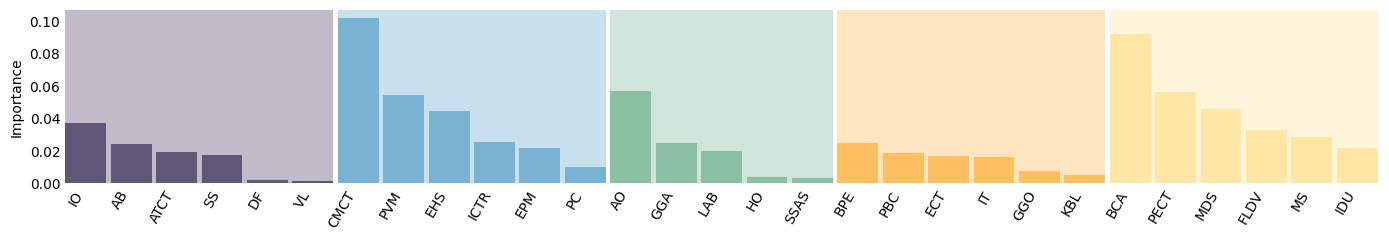

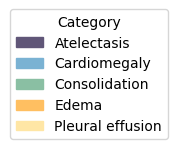

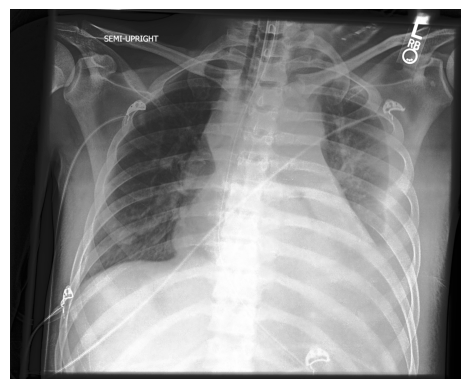

In [404]:
chest_sample_explain("test/patient64830/study1/view1_frontal.jpg","all",top_number=1000,importance_matric="abs_stn")

In [403]:
def chest_class_explain(class_id):
    df = pd.read_csv(test_csv)
    image_files  = df.iloc[:, 0].tolist()
    image_files = [os.path.join(folder_path, x) for x in image_files]
    # df_selected = df[attr_names]
    class_name= attr_names[class_id]
    activ.get_one_class_stats(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{class_name}.pkl", label_csv =df, attr_names = attr_names, class_idx=class_id,folder_path=folder_path)

    
    filename = get_filename(model_name,"biomedclip")
    df = pd.read_csv(filename)
    
    """
    通过weight
    """
    model,_ = models.load(model_name,"cuda")
    weights = model.fc.weight.data
    class_weight = weights[class_id]
    
    top_weights, top_indices = torch.topk(class_weight, 5)

    # 输出权重和对应的索引
    print(f"Top 20 weights and their indices for class {class_id}:")
    for weight, idx in zip(top_weights, top_indices):
        print(f"Weight: {weight.item()}, Index: {idx.item()}")
        target_row = df.iloc[idx.item()]
        description = target_row["description"] if target_row['similarity'] > 1 else "Undefined"
        print(description,target_row['similarity'])

    """
    通过importance_matric
    # """
    f = open(f"activs_stats/{target_save_name}/{class_name}.pkl","rb")
    data = pickle.load(f) #[gradient, max_activations, mean_activations]
    f.close()
    ori_gradients = data[:, :, 0]
    ori_activations = data[:, :, 2]
    
    print("------------------------------------")
        
    gradients,activations=apply_importance_matric(ori_gradients,ori_activations,importance_matric="abs_pos")
    # top_important_idxs, top_k_values = neuron_finding.get_max_weighted_activate_neuron(gradients, activations, k=10)
    top_important_idxs, top_k_values = neuron_finding.get_max_weighted_activate_neuron(class_weight.cpu().detach().numpy(), activations, k=10)
    for idx,value in zip(top_important_idxs, top_k_values):
        print(f"Neuron {idx} has a max weight of {value}")
        target_row = df.iloc[idx]
        description = target_row["description"] if target_row['similarity'] > 1 else "Undefined"
        print(description,target_row['similarity'])
# chest_class_explain(3)